# This will just read soil data and create a list of all soil coordinates which are then stored in an output file to be read by gdal script which will create image bboxes around each coordinate of square side 2r (with center at these coordinates)

In [1]:
# In particular we now include the correct dates for weather grouping for hostvete 
# which begin from seed date -> 1st Nov year before + 15Marh->midsummer + midsummer -> max harvest date

# We load all soil, field, year and weather data for all fields in Heddinge and predict 
# the harvest for that field during a single year: 2017, 2018, 2019 or 2020

# Also change the grouping in time for weather data to just a single season (Aug 2)
# instead of the previous weekly grouping

# We segment per crop and year in this particular notebook (July 31, Aug 1)

# First start the VPN in order to download all necessary data 

In [16]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install shapely
!{sys.executable} -m pip install pyproj
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install psycopg2-binary
!{sys.executable} -m pip install geojson
!{sys.executable} -m pip install postgis
!{sys.executable} -m pip install sqlalchemy
!{sys.executable} -m pip install shap

In [30]:
import postgis
import psycopg2
import sqlalchemy
import datetime
import matplotlib
import pandas as pd
from tqdm import tqdm

In [9]:
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
        
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

In [10]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    
    return df

In [11]:
def calltoVPN(param_dic, textcom):
    
    # opening the VPN connection
    dbConnection = connect(param_dic) # Connect to PostgreSQL server
    
    start_time = datetime.datetime.now()        
    dfout = pd.read_sql_query(textcom, dbConnection)
    dif = datetime.datetime.now()-start_time
    print("Time to complete request:", dif.seconds, "sec.")
    
    # Close the database connection
    dbConnection.close();
    print("Connection closed")
    
    return dfout # output containing the response in a dataframe table

In [12]:
# Defining the different possible calls to be used later
def chose_a_call(argument,  region_name='Heddinge', crop_name='Höstvete',fieldID = 123456789):
    switcher = {
        # Gets blockids from cultivation - Heddinge only
        1: '''SELECT blockid FROM agri.cultivation WHERE farmname = 'Heddinge' ''',
        
        # Gets all from soil - specific field only
        2: '''SELECT * FROM agri.soil_sample u,agri.cult_union c \
        WHERE c.blockid = '''+str(fieldID),
        
        # Gets all from cultivation - specific: Varvete, Heddinge and seed_date
        3: '''SELECT * FROM agri.cultivation WHERE crop = 'Vårvete' \
        AND farmname = 'Heddinge' AND extract(month from seed_date) < 7''',
        
        # Gets all from cultivation - specific: Varvete, Heddinge and seed_date
        4: '''SELECT * FROM agri.cultivation WHERE crop = 'Vårkorn' \
        AND farmname = 'Heddinge' AND extract(month from seed_date) < 7\
        AND yield_harvester_measured > 0 AND humus_average < 10 ORDER BY blockid ''',
        
        # Gets all from cultivation - specific: Varvete, Heddinge and seed_date
        5: '''SELECT * FROM agri.cultivation WHERE crop = 'Höstvete' \
        AND farmname = 'Heddinge' AND extract(month from seed_date) < 7''',
        
        # unfinished call - do not use
        6: '''agri.cultivation SET crop = 'Höstvete' \
        WHERE crop ILIKE '%vete%' AND extract(month from seed_date) > 6;''',
        
        # Gets all fields from cultivation - specific: yield, humus
        7: '''SELECT * FROM agri.cultivation WHERE crop = 'Vårvete' \
        AND farmname = 'Heddinge' AND yield_harvester_measured > 0 AND humus_average < 10 ORDER BY blockid''',
        
        # This is latest command from Andreas about hostvete  #Vårkorn
        8: '''SELECT blockid FROM agri.cultivation WHERE crop = 'Höstvete' \
        AND farmname = ''' + region_name +''' AND yield_harvester_measured > 2500 \
        AND blockid IS NOT NULL AND seed_date IS NOT NULL;''',
        
        # This is latest command from Andreas about varkorn
        9: '''SELECT blockid, harvest_year FROM agri.cultivation WHERE crop = 'Vårkorn' \
        AND farmname = 'Heddinge' AND yield_harvester_measured > 2500 \
        AND blockid IS NOT NULL AND seed_date IS NOT NULL;''',
    }
    return switcher.get(argument,"Invalid choise")

## Hyper

In [57]:
# Year chosen to study. For some crops we include weather from fall season in year before (due to seeding)
year_chosen = 2018

# radius in meter chosen to spatially group together soil and harvest
r=50

# Region chosen
#region_name = "'Brandstad'"
region_name = "'Heddinge'"

# Crop chosen to study
crop_name = "'Höstvete'"
#crop_name = "'Vårkorn'"

## Setting up and initiating VPN 

In [58]:
# Connection parameters, yours will be different
param_dic = {
    "host" : "172.16.16.38",
    "port" : 5432,
    "database" : "agtech",
    "user" : "user_read",
    "password" : "Langtnog987",
    "options"   : "-c search_path=agri,public"
}

### Call to obtain a list of farms (blockids) in Heddinge with given properties

In [59]:
# Call to find out the blockids (to be used later in the main calls)

textcom = chose_a_call(8,region_name) # "'Heddinge'")#

testdf4 = calltoVPN(param_dic, textcom)
print("Number of fields found:", testdf4.shape)

#len(testdf4["farmname"].unique()) #['blockid'][2]

Connecting to the PostgreSQL database...
Connection successful
Time to complete request: 0 sec.
Connection closed
Number of fields found: (60, 1)


In [60]:
testdf4

,blockid
0,6.170337e+10
1,6.165341e+11
2,6.175372e+11
3,6.177342e+10
4,6.168341e+10
5,6.175341e+10
6,6.167341e+10
7,6.169338e+10
8,6.165342e+10
9,6.175371e+10


In [61]:
# Defining the different possible calls to be used later
def new_calls(argument,  region_name = "'Heddinge'", crop_name="'Vårvete'",fieldID = 123456789):
    switcher = {
        
        # This is for weather 
        2: #"Select * FROM agri.weather ORDER BY year ASC",#w.temperature AS w_temperature, \
        "SELECT w.precipitation AS w_precipitation, \
        w.year AS w_year, \
        w.time AS w_time \
        FROM agri.cultivation c,agri.weather w \
        WHERE c.blockid = " + str(fieldID)+ "\
        AND extract(month from w.time) < 11 \
        AND extract(month from w.time) > 2 \
        ORDER BY year ASC",
        
        # This is for harvest
        1:
        "SELECT ST_X(u.geom) AS h_coord_X, ST_Y(u.geom) AS h_coord_Y, \
        c.blockid AS h_blockid, \
        u.year AS h_year, \
        u.time AS h_time, \
        u.harvest AS h_harvest, \
        u.water_percentage AS h_water_percentage \
        FROM agri.harvest u, agri.cult_union c WHERE c.blockid = "+str(fieldID)+" \
        AND ST_Intersects(c.geom, u.geom) \
        AND u.crop = 'Vete' \
        AND u.edgeflag = 'False' \
        ORDER BY year,id ASC",
        #+ crop_name +" \
        #
        
        # This is for soil
        0: #'''SELECT ST_X(u.geom) AS coord_X, ST_Y(u.geom) AS coord_Y FROM agri.soil_sample u,agri.cult_union c WHERE c.blockid = '''+str(fieldID),
        '''SELECT ST_X(u.geom) AS coord_X, ST_Y(u.geom) AS coord_Y, \
        u.ph AS s_ph, \
        u.humus_percentage AS s_hum100, \
        u.clay_percentage AS s_clay100, \
        u.phosphorus AS s_phosphorus, \
        u.calcium AS s_calcium, \
        u.potassium AS s_K, u.magnesium AS s_mg \
        FROM agri.soil_sample u,agri.cult_union c WHERE c.blockid = '''+str(fieldID)+''' \
        AND ST_IsValid(c.geom) \
        AND ST_Intersects(c.geom,u.geom) \
        AND u.youngest = 'True' ORDER BY year,id ASC''',
        #
        
        
        # This is for field
        3:'''SELECT \
        blockid AS f_blockid,\
        seed_date AS f_seed_date, \
        seed_amount AS f_seed_amount, \
        harvest_date AS f_harvest_date, \
        yield_harvester_measured AS f_yield_harvester_measured, \
        yield_water_percentage AS f_yield_water_percentage, \
        fertilizer_date AS f_fertilizer_date, \
        fertilizer_amount AS f_fertilizer_amount, \
        humus_average AS f_humus_average, \
        humus_stddev AS f_humus_stddev,\
        ph_average AS f_ph_average, \
        ph_stddev AS f_ph_stddev, \
        weatherstation AS f_weatherstation, \
        weatherstation_dist AS f_weatherstation_dist, \
        blockid_org AS f_blockid_org, \
        nitrogen AS f_nitrogen, \
        kalium AS f_kalium, \
        phosphorus AS f_phosphorus, \
        sulphur AS f_sulphur, \
        calcium AS f_calcium, \
        magnesium AS f_MG, \
        nitrogen_earlier AS f_nitrogen_earlier, \
        edgeflag_percentage AS f_edgeflag_percentage \
        FROM agri.cultivation  \
        WHERE crop = ''' + crop_name +''' \
        AND farmname = 'Brandstad' \
        AND blockID = '''+str(fieldID),
        # slopeness AS f_slopeness, \
        #nitrogen_secondary AS f_nitrogen_secondary, \
        #weather_precipitation AS f_weather_precip, \
        #weather_temperature AS f_weather_temp, \
        #harvest_year AS f_har_year, \
        #crop AS f_crop, \
        #geom AS f_geom, \
        #yield_amount AS f_yield_amount, \
        #''' + region_name +''' \
        # Gets all from soil_sample - specific: youngest, fieldID
        5:'''SELECT * FROM agri.soil_sample WHERE youngest = 'True' \
        AND c.blockid = '''+str(fieldID),
        
        # Unfinished call - do not use
        10: "SELECT a.id,a.year,b.id,b.year,ST_X(a.geom),ST_X(b.geom) \
        FROM agri.soil_sample a,agri.soil_sample b WHERE ST_DWithin(a.geom,b.geom,10) \
        AND a.id <> b.id AND a.year <> b.year ORDER BY ST_X(a.geom),a.year;"
    }
    return switcher.get(argument,"Invalid choise - by myself")

# WHERE crop ILIKE '%vete%'  

### Cleaning up selection - getting rid of NaNs

In [62]:
Hed_fields = list(testdf4["blockid"].unique()) #["farmname"].unique() #['blockid'][2]
Hed_fields = [int(l) for l in Hed_fields if str(l) != 'nan']
print("number of fields remaining after cleaning: ", len(Hed_fields))

number of fields remaining after cleaning:  48


## Calls to database 

In [63]:
#year_chosen = 2019 # Important - this is the year for the data to do analysis upon

#crop_name="'Höstvete'" #"
#crop_name = "'Vårkorn'"

onlyfiles = [l for l in Hed_fields]#[:3]]
#print(onlyfiles)
# Connect to PostgreSQL server
dbConnection = connect(param_dic)

# dict to load all soil, weather, harvest and year data for fields in "onlyfiles" list
all_dfs = {}

#textcom = [textfiel, textsoil, textweat, textharv]
#paths = ["field", "soil","weather",  "harvest"]
paths = ["soil"]
dfs = {0:'s'}

for cnt in tqdm(range(len(dfs))):#range(len(dfs)):#df_chosen in tqdm(dfs):#, path_chosen in zip(dfs, paths):
    print("Now importing all ", paths[cnt], " data.")
    df_chosen = dfs[cnt]
    tempdf = pd.DataFrame()
    start_time = datetime.datetime.now()
    for fieldID in onlyfiles: # Loop through all fields in list onlyfiles
        #print("now working with field ", fieldID)
        texttouse = new_calls(cnt, region_name, crop_name, fieldID)
        tempdf = tempdf.append(pd.read_sql_query(texttouse, dbConnection))
    dif = datetime.datetime.now()-start_time
    print("Finished with all",paths[cnt]," data. Downloaded ",len(tempdf)," rows. That took", dif.seconds, "sec. \n")
    all_dfs[df_chosen] = tempdf
    
# Close the database connection
dbConnection.close();
print("Connection closed")

  0% 0/1 [00:00<?, ?it/s]

Connecting to the PostgreSQL database...
Connection successful
Now importing all  soil  data.


100% 1/1 [00:01<00:00,  1.48s/it]

Finished with all soil  data. Downloaded  340  rows. That took 1 sec. 

Connection closed


In [64]:
soildf = all_dfs['s'].copy() # soil data
#tempdf = all_dfs['w'].copy() # weather data
#harvdf = all_dfs['h'].copy() # harvest data
#fieldf = all_dfs['f'].copy() # field data

#fieldf = fieldf[fieldf['f_blockid'].notna()] # remove all rows where blockid is NaN


In [65]:
df = soildf.copy()
df.shape

(340, 9)

In [66]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

In [67]:
missing_value_df

,column_name,percent_missing
coord_x,coord_x,0.0
coord_y,coord_y,0.0
s_ph,s_ph,0.0
s_hum100,s_hum100,0.0
s_clay100,s_clay100,0.0
s_phosphorus,s_phosphorus,0.0
s_calcium,s_calcium,0.0
s_k,s_k,0.0
s_mg,s_mg,0.0


# Soil Data Import and Processing/Clean Up

Now include the ratio of K/Mg as an extra column in the dataframe

In [68]:
soildf['s_K/Mg'] = soildf['s_k']/soildf['s_mg']

In [69]:
nnsoildf = soildf
nnsoildf.head()


,coord_x,coord_y,s_ph,s_hum100,s_clay100,s_phosphorus,s_calcium,s_k,s_mg,s_K/Mg
0,391614.4,6162769.6,8.1,13.2,18,9.6,1200.0,12.0,24.0,0.500000
1,391720.0,6162971.8,7.4,3.8,28,8.4,390.0,15.0,18.0,0.833333
2,391508.6,6162928.3,8.4,3.0,36,9.2,2000.0,21.0,27.0,0.777778
3,391588.8,6163343.0,7.8,3.6,38,6.1,450.0,20.0,15.0,1.333333
4,391735.2,6163128.8,7.0,4.2,25,4.1,320.0,13.0,12.0,1.083333


In [70]:
print("the shape of soil data for this field is ", nnsoildf.shape)

the shape of soil data for this field is  (340, 10)


# Create list from soil coordinates and output to file

Create output file to hold the centers lists

In [71]:
xcenters = list(soildf.iloc[:,0])
ycenters = list(soildf.iloc[:,1])

In [72]:
import pickle

# storing list to file 
with open("centers_Heddinge_hostvete.txt", 'wb') as f:
    pickle.dump((xcenters, ycenters), f)


In [56]:
# Testing that it worked
# loading list from file
with open("centers.txt", 'rb') as f:
   testx, testy = pickle.load(f)
testx==xcenters

True

End of file

In [97]:
# #cols_to_keep = ["time", "year", "temperature", "precipitation"]
# #ntempdf = tempdf[cols_to_keep]#["temperature"][:20]

# # First change the date column to datetime object
# # Convert date and time to just datetime object with only date
# format_string = "%Y-%m-%d"
# tempdf["w_time"] = pd.to_datetime(tempdf["w_time"], format = format_string)

# # choose to keep year 2020
# tempdf = elim(tempdf, "w_year", year_chosen)

In [98]:
tempdf

,w_precipitation,w_year,w_time
0,0.0,2000,2000-09-29
1,0.5,2000,2000-08-15
2,8.3,2000,2000-08-14
3,0.0,2000,2000-08-13
4,0.0,2000,2000-08-12
...,...,...,...
14699,1.0,2021,2021-05-26
14700,20.0,2021,2021-05-25
14701,0.0,2021,2021-05-24
14702,0.8,2021,2021-05-23


In [99]:
fieldf

,f_blockid,f_seed_date,f_seed_amount,f_harvest_date,f_yield_harvester_measured,f_yield_water_percentage,f_fertilizer_date,f_fertilizer_amount,f_humus_average,f_humus_stddev,...,f_weatherstation_dist,f_blockid_org,f_nitrogen,f_kalium,f_phosphorus,f_sulphur,f_calcium,f_mg,f_nitrogen_earlier,f_edgeflag_percentage
0,6.174367e+11,2018-09-18,185.0,2019-07-24,23836.4,18,2019-03-27,265.0,4.5,0.4,...,9815,6.174367e+10,279.0,49.0,17.0,34.0,24.0,0.0,0,13.0
0,6.175368e+10,2018-09-17,185.0,2019-07-24,10445.2,14,2019-03-29,275.0,6.4,1.8,...,8794,6.175368e+10,417.0,172.0,35.0,27.0,19.0,0.0,40,12.0
0,6.177367e+10,2018-09-19,200.0,2019-07-24,18166.4,14,2019-03-29,275.0,4.5,1.2,...,6758,6.177367e+10,213.0,28.0,8.0,24.0,30.0,0.0,0,9.0
0,6.174367e+11,2018-09-22,200.0,2019-07-24,25024.6,16,2019-03-27,275.0,4.1,0.4,...,9931,6.174367e+10,319.0,58.0,17.0,31.0,29.0,0.0,40,9.0
0,6.174369e+11,2018-09-24,200.0,2019-07-24,12134.2,17,2019-03-28,275.0,5.7,1.7,...,9500,6.174369e+10,233.0,28.0,8.0,25.0,29.0,0.0,0,15.0
0,6.175367e+10,2018-09-17,185.0,2019-07-24,5551.5,16,2019-03-29,275.0,5.4,0.1,...,9235,6.175367e+10,397.0,172.0,35.0,27.0,24.0,0.0,0,16.0
0,6.173372e+10,2018-09-14,185.0,2019-07-24,3552.1,15,2019-03-29,275.0,None,None,...,11890,6.173372e+10,280.0,58.0,17.0,31.0,27.0,0.0,0,17.0
0,6.173372e+10,2018-09-14,185.0,2019-07-24,15304.2,16,2019-03-29,275.0,None,None,...,10976,6.173372e+10,281.0,58.0,17.0,31.0,24.0,0.0,0,13.0
0,6.175371e+10,2018-09-25,200.0,2019-07-24,4398.8,12,2019-03-28,275.0,None,None,...,8845,6.175371e+10,280.0,58.0,17.0,31.0,29.0,0.0,0,28.0
0,6.175368e+10,2018-09-17,185.0,2019-07-24,3640.9,20,2019-03-29,275.0,5.5,1.1,...,9130,6.175368e+10,421.0,172.0,35.0,27.0,0.0,0.0,40,20.0


In [100]:
# # Create figure and plot space
# fig, ax = plt.subplots(figsize=(12, 12))

# # Add x-axis and y-axis
# ax.bar(tempdf["w_time"],#.index.values,
#        tempdf["w_precipitation"],#['DAILY_PRECIP'],
#        color='purple')
# # Add x-axis and y-axis
# #ax.scatter(boulder_july_2018.index.values,
# #        boulder_july_2018['precip'],
# #        color='purple')

# # Create figure and plot space
# #fig, ax = plt.subplots(figsize=(10, 10))

# # Add x-axis and y-axis
# #ax.plot(boulder_july_2018['date'],
# #        boulder_july_2018['precip'],
# #        color='purple')


# # Set title and labels for axes
# ax.set(xlabel="Date",
#        ylabel="Precipitation (inches)",
#        title="Daily Total Precipitation\nBoulder, Colorado in July 2018")

# # Rotate tick marks on x-axis
# plt.setp(ax.get_xticklabels(), rotation=45)

# # Set title and labels for axes
# #ax.set(xlabel="w_time",
# #       ylabel="w_precipitation",
# #       title="Daily Total Precipitation\nJune - Aug 2005 for Boulder Creek")

# plt.show()


## Grouping weather data by Seasons, Month, week - do a total 

Total average of all columns

In [101]:
tempdf = all_dfs['w'].copy() # weather data
tempdf 

,w_precipitation,w_year,w_time
0,0.0,2000,2000-09-29
1,0.5,2000,2000-08-15
2,8.3,2000,2000-08-14
3,0.0,2000,2000-08-13
4,0.0,2000,2000-08-12
...,...,...,...
14699,1.0,2021,2021-05-26
14700,20.0,2021,2021-05-25
14701,0.0,2021,2021-05-24
14702,0.8,2021,2021-05-23


In [102]:
def cutoutseason(datafrin, seasonb, seasone):
    #print("call to whole datafrin (as a list):", datafrin)#["w_time"])
    #print("seasonb=", seasonb)
    # print(seasone)
    
    #datafrin['w_time'] = datafrin['w_time'].dt.date
    datafrout = datafrin[datafrin["w_time"]>seasonb]
    datafrout = datafrout[datafrout["w_time"]<seasone]
    
    return datafrout

In [103]:
# Defining the different possible groupings to choose from 
# 0: group all weather data into a single group
# 1: group all weather data per 3 season (specific dates)
# 2: group all weather data per day
# 3: group all weather data per week
# 4: group all weather data per month

def group_weather(argument, tempdf, fieldf, year_chosen):#, fieldID = 123456789):
      
    print("The following will be used for weather grouping:")
    # Find minimum date of seeding
    min_seed_date = min(fieldf[fieldf["f_seed_date"]>datetime.date(year_chosen-1,9,2)]["f_seed_date"])#.shape
    print("The earliest seeding date is ", min_seed_date)

    # Get harvest date for this dataset
    max_harv_date = max(fieldf[fieldf["f_harvest_date"]<datetime.date(year_chosen,9,1)]["f_harvest_date"])
    print("MAximum harvest time: ", max_harv_date)
    #max_harv_date = max(fieldf[fieldf["f_harvest_date"]>datetime.date(year_chosen,7,1)]["f_seed_date"])

    # Season 1: Seed-start-> 1st Nov
    season1st  = min_seed_date
    season1end = datetime.date(year_chosen-1,11,1) # November 1st
    
    # Season 2: 15 March  -> Midsummer
    season2st  = datetime.date(year_chosen,3,15)   # March 15
    season2end = datetime.date(year_chosen,6,25)   # June 25 (midsummer)
    
    # Season 3: Midsummer -> Harvest date
    season3st  = datetime.date(year_chosen,6,26)   # June 26 (after midsummer)
    season3end = max_harv_date

    print("Dates for season 1: ", season1st, season1end)
    print("Dates for season 2: ", season2st, season2end)
    print("Dates for season 3: ", season3st, season3end)

    format_string = "%Y-%m-%d"
    tempdf["w_time"] = pd.to_datetime(tempdf["w_time"], format = format_string)
    
    ttempdf = tempdf.copy()
    ttempdf['w_time'] = tempdf['w_time'].dt.date # only for t1
    t1 = cutoutseason(ttempdf, season1st, season1end)

    if len(t1) == 0:
        print("Problems!!!")
        print("t1",t1)

    t2 = cutoutseason(ttempdf, season2st, season2end)  

    t3 = cutoutseason(ttempdf, season3st, season3end)

    tttempdf = t1.copy()
    tttempdf = tttempdf.append(t2, ignore_index=True)
    tttempdf = tttempdf.append(t3, ignore_index=True)
    
    ntempdf = pd.DataFrame(columns=tempdf.columns)
    
    if argument == 0:   # average all data into a single group (as an average)
        print("\n Grouping everything into single group! \n")

        ttempdf['w_time'] = cutoutseason(tttempdf, season1st, season1end)
        ntempdf.loc['mean'] = ttempdf.mean() # do an average over the total
        
    elif argument == 1: # average over specific seasons 
        print("\n Grouping into 3 seasons! \n")
 
        l = pd.Series([t1.mean()["w_precipitation"], t2.mean()["w_precipitation"], t3.mean()["w_precipitation"]])
        lw = pd.Series([t1.mean()["w_year"], t2.mean()["w_year"], t3.mean()["w_year"]])
        
        ntempdf["w_precipitation"] = l
        ntempdf["w_year"] = lw
        #ntempdf # this is weather grouped by season
    elif argument == 2: # group weather data per week (as an average)
        print("\n Grouping per day! \n")
        #format_string = "%Y-%m-%d"
        #tempdf["w_time"] = pd.to_datetime(tempdf["w_time"], format = format_string)

        # choose to keep year 2020
        #tempdf = elim(tempdf, "w_year", year_chosen)
        ttempdf = tttempdf.copy()
        
        groupby = "D"  # group by week, (M) Month. Alternatively "D" for day
        ntempdf = tttempdf.groupby(pd.Grouper(key='w_time',freq = groupby)).mean()
    elif argument == 3: # group weather data per week (as an average)
        print("\n Grouping per week! \n")
        format_string = "%Y-%m-%d"
        ttempdf = tttempdf.copy()
        ttempdf["w_time"] = pd.to_datetime(tttempdf["w_time"], format = format_string)

        # choose to keep year 2020
        #tempdf = elim(tempdf, "w_year", year_chosen)
        
        groupby = "W"  # group by week, (M) Month. Alternatively "D" for day
        ntempdf = ttempdf.groupby(pd.Grouper(key='w_time',freq = groupby)).mean()
        
    elif argument == 4: # group weather data per month (as an average)
        print("\n Grouping per month! \n")
        # First change the date column to datetime object
        # Convert date and time to just datetime object with only date
        format_string = "%Y-%m-%d"
        ttempdf = tttempdf.copy()
        ttempdf["w_time"] = pd.to_datetime(tttempdf["w_time"], format = format_string)

        # choose to keep year 2020
        #tempdf = elim(tempdf, "w_year", year_chosen)

        groupby = "M"  # group by week, (M) Month. Alternatively "D" for day
        ntempdf = ttempdf.groupby(pd.Grouper(key='w_time',freq = groupby)).mean()
    ntempdf.dropna(subset = ["w_year"], inplace=True) # remove rows of NaN
        
    
    return ntempdf

In [104]:
# Groupings to choose from: 
# 0: group all weather data into a single group
# 1: group all weather data into 3 seasons (specific dates)
# 2: group all weather data per day
# 3: group all weather data per week
# 4: group all weather data per month

new_tempdf = group_weather(1, tempdf, fieldf, year_chosen)

The following will be used for weather grouping:
The earliest seeding date is  2018-09-07


ValueError: max() arg is an empty sequence

In [23]:
new_tempdf

,w_precipitation,w_year,w_time
0,2.160714,2016.0,NaN
1,1.580693,2017.0,NaN
2,1.686133,2017.0,NaN


In [24]:
new_tempdf

,w_precipitation,w_year,w_time
0,2.160714,2016.0,NaN
1,1.580693,2017.0,NaN
2,1.686133,2017.0,NaN


## Clean weather dataframe 

In [25]:
clean_weather_df = new_tempdf

# Harvest Data Processing/Clean Up

### Chose a specific year for harvest

In [26]:
# Note that field id = ...7601 is full of edgeflag == True ! 
# So we keep all data even if flagged as edge
#harvdf = all_dfs['h']
nharvdf = harvdf[harvdf["h_year"]==year_chosen]

# Remove data near field edges - according to provided flag within data
# nfielddf = elim(fielddf,'edgeflag', False)
# nfielddf = fielddf

Removing all edge data (i.e. edgeflag == True)

In [27]:
# Remove edges
#tempdf = nharvdf[nharvdf["edgeflag"]==False]
#tempdf
#nharvdf = nharvdf[nharvdf["edgeflag"]==False]
nharvdf#["h_year"].unique()

,h_coord_x,h_coord_y,h_blockid,h_year,h_time,h_harvest,h_water_percentage
0,391893.9,6163203.9,6.165341e+11,2017,2017-08-24 20:14:50,7.9,17.5
1,391893.4,6163203.7,6.165341e+11,2017,2017-08-24 20:14:51,10.2,17.5
2,391892.7,6163203.4,6.165341e+11,2017,2017-08-24 20:14:52,7.7,17.5
3,391892.0,6163203.1,6.165341e+11,2017,2017-08-24 20:14:53,5.8,17.5
4,391891.4,6163202.9,6.165341e+11,2017,2017-08-24 20:14:54,5.4,17.6
...,...,...,...,...,...,...,...
1439,420982.3,6173049.2,6.175371e+10,2017,2017-09-03 16:18:50,0.6,19.7
1440,420982.0,6173047.6,6.175371e+10,2017,2017-09-03 16:18:51,1.0,19.8
1441,420981.6,6173046.0,6.175371e+10,2017,2017-09-03 16:18:52,1.3,19.9
1442,420981.2,6173044.1,6.175371e+10,2017,2017-09-03 16:18:53,1.3,19.9


In [28]:
# Choose data from 2018
#nfielddf = elim(nfielddf, "year", 2018)
cols_to_keep = ["h_coord_x", "h_coord_y", "h_blockid", "h_harvest", "h_water_percentage"]
#harv_rem_cols= ["crop",'data_id','farmname','data_geom','edgeflag']
#nnfielddf = cleanDataFrame(nfielddf, harv_rem_cols)
nnharvdf = nharvdf[cols_to_keep]
nnharvdf

,h_coord_x,h_coord_y,h_blockid,h_harvest,h_water_percentage
0,391893.9,6163203.9,6.165341e+11,7.9,17.5
1,391893.4,6163203.7,6.165341e+11,10.2,17.5
2,391892.7,6163203.4,6.165341e+11,7.7,17.5
3,391892.0,6163203.1,6.165341e+11,5.8,17.5
4,391891.4,6163202.9,6.165341e+11,5.4,17.6
...,...,...,...,...,...
1439,420982.3,6173049.2,6.175371e+10,0.6,19.7
1440,420982.0,6173047.6,6.175371e+10,1.0,19.8
1441,420981.6,6173046.0,6.175371e+10,1.3,19.9
1442,420981.2,6173044.1,6.175371e+10,1.3,19.9


In [29]:
if (nnharvdf["h_harvest"]=='nan').any():
    print("Some NaN values exist - Need to remove")
else:
    print("No NaN values. Good to go!")

No NaN values. Good to go!


### Now work on spatial proximity grouping between datasets

First with Harvest: for a given square with side length 2r we group together (sum) all harvest data which are within that distance for each coordinate in the soil data.

In [30]:
df=nnharvdf
df

,h_coord_x,h_coord_y,h_blockid,h_harvest,h_water_percentage
0,391893.9,6163203.9,6.165341e+11,7.9,17.5
1,391893.4,6163203.7,6.165341e+11,10.2,17.5
2,391892.7,6163203.4,6.165341e+11,7.7,17.5
3,391892.0,6163203.1,6.165341e+11,5.8,17.5
4,391891.4,6163202.9,6.165341e+11,5.4,17.6
...,...,...,...,...,...
1439,420982.3,6173049.2,6.175371e+10,0.6,19.7
1440,420982.0,6173047.6,6.175371e+10,1.0,19.8
1441,420981.6,6173046.0,6.175371e+10,1.3,19.9
1442,420981.2,6173044.1,6.175371e+10,1.3,19.9


#### Visual check of harvest and soil data locations

#### Clean up all soil and harvest data which are not near each other (with r)

We choose a length r and any data which does not overlap is removed

In [31]:
nnharvdf.keys()
#nnharvdf.drop(11447)

Index(['h_coord_x', 'h_coord_y', 'h_blockid', 'h_harvest',
       'h_water_percentage'],
      dtype='object')

In [32]:
nnsoildf.shape

(340, 10)

In [33]:
# Re-group harvest data according to coordinates in soil
new_harv_df, new_soil_df = remdata(nnharvdf, nnsoildf, r)

100% 340/340 [00:13<00:00, 25.71it/s]

Soil shape (166, 10)
Harv shape (166, 5)


In [34]:
BBox = (df.h_coord_x.min(),   df.h_coord_x.max(),   df.h_coord_y.min(), df.h_coord_y.max())
BBox

(388920.6, 422626.3, 6161728.2, 6173605.1)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


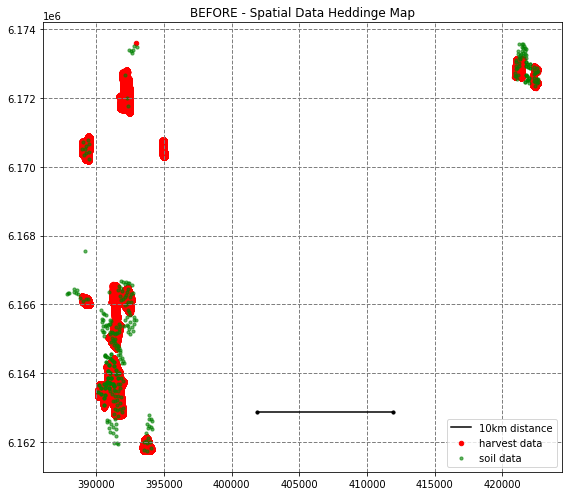

In [35]:
fig, ax = plt.subplots(figsize = (8,7))
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
ax.scatter(nnharvdf.h_coord_x, nnharvdf.h_coord_y, zorder=1, alpha= 1.0, c='r', s=20, label='harvest data')
#for xh, yh in zip(df.h_coord_x[10:], df.h_coord_y[10:]):
#    cir = plt.Circle((xh, yh), 10.0, color='k',fill=True)#False)
ax.scatter(nnsoildf.coord_x, nnsoildf.coord_y, zorder=1, alpha= 0.6, c='g', s=10, label = 'soil data')
ax.set_title('BEFORE - Spatial Data Heddinge Map')
#ax.set_aspect('equal', adjustable='datalim')
#ax.add_patch(cir)
#ax.set_xlim(BBox[0]-2000,BBox[1]+1000)
#ax.set_ylim(BBox[2]+10000,BBox[3]-10000)
ax.plot([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
        color='k', label = '10km distance')
ax.scatter([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
           zorder=1, alpha= 1., c='k', s=10)
ax.grid(color='grey', linestyle='--', linewidth=1)
plt.tight_layout()   
leg = plt.legend(loc="best")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


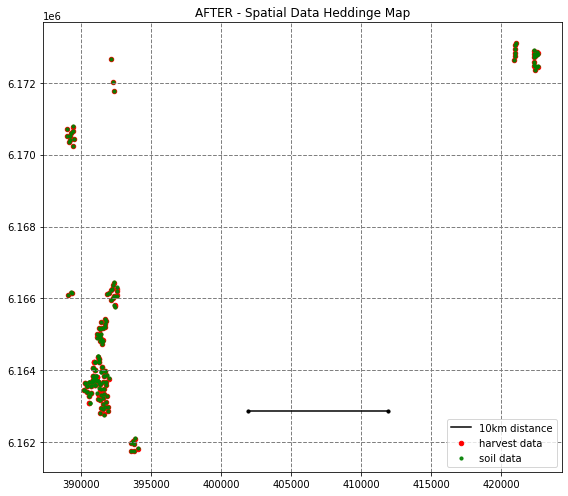

In [36]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(new_harv_df.h_coord_x, new_harv_df.h_coord_y, zorder=1, alpha= 1.0, c='r', s=20, label='harvest data')
#for xh, yh in zip(df.h_coord_x[10:], df.h_coord_y[10:]):
#    cir = plt.Circle((xh, yh), 10.0, color='k',fill=True)#False)
ax.scatter(new_soil_df.coord_x, new_soil_df.coord_y, zorder=1, alpha= 0.9, c='g', s=10, label = 'soil data')
ax.set_title('AFTER - Spatial Data Heddinge Map')
#ax.set_aspect('equal', adjustable='datalim')
#ax.add_patch(cir)
#ax.set_xlim(BBox[0],BBox[1])
#ax.set_ylim(BBox[2],BBox[3])
ax.plot([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
        color='k', label = '10km distance')
ax.scatter([10000+nnsoildf.iloc[5,0],10000+nnsoildf.iloc[5,0]+10000],[nnsoildf.iloc[5,1],nnsoildf.iloc[5,1]], \
           zorder=1, alpha= 1., c='k', s=10)
ax.grid(color='grey', linestyle='--', linewidth=1)
plt.tight_layout()   
leg = plt.legend()

In [37]:
new_harv_df.head()

,h_coord_x,h_coord_y,h_blockid,h_harvest,h_water_percentage
0,388958.218033,6.170516e+06,6.173339e+10,11.142008,16.148566
1,388985.555263,6.170704e+06,6.173339e+10,11.651238,17.100310
2,389011.218648,6.166091e+06,6.169339e+10,10.049073,16.951799
3,389111.663658,6.170344e+06,6.173339e+10,11.986580,16.159382
4,389190.432246,6.170530e+06,6.173339e+10,12.449310,16.060477


In [38]:
new_soil_df.head()

,coord_x,coord_y,s_ph,s_hum100,s_clay100,s_phosphorus,s_calcium,s_k,s_mg,s_K/Mg
9,388937.7,6170516.6,6.7,2.2,15,10.0,210.0,7.9,4.4,1.795455
10,388979.3,6170716.0,8.1,2.0,19,14.0,820.0,16.0,7.3,2.191781
11,389008.2,6166086.7,8.1,3.4,14,11.0,370.0,10.0,7.3,1.369863
12,389113.6,6170344.7,7.1,1.9,24,6.8,290.0,14.0,8.2,1.707317
14,389190.4,6170529.5,6.8,2.0,17,2.2,210.0,9.0,5.9,1.525424



Check if some values of harvest are 0 or non existent (nan)
Later on we remove all such rows from both harvest and soil (after merging them toghether)

In [39]:
#tempdf = newdf
#harvdf#["harvest"].unique()
print("note: for this to work both soil and re-grouped harvest (i.e. newdf) must have the exact same number of rows.")
print("Soil shape:", new_soil_df.shape)
print("Re-grouped Harvest shape:", new_harv_df.shape)

note: for this to work both soil and re-grouped harvest (i.e. newdf) must have the exact same number of rows.
Soil shape: (166, 10)
Re-grouped Harvest shape: (166, 5)


In [40]:
new_harv_df

,h_coord_x,h_coord_y,h_blockid,h_harvest,h_water_percentage
0,388958.218033,6.170516e+06,6.173339e+10,11.142008,16.148566
1,388985.555263,6.170704e+06,6.173339e+10,11.651238,17.100310
2,389011.218648,6.166091e+06,6.169339e+10,10.049073,16.951799
3,389111.663658,6.170344e+06,6.173339e+10,11.986580,16.159382
4,389190.432246,6.170530e+06,6.173339e+10,12.449310,16.060477
...,...,...,...,...,...
161,422507.818293,6.172790e+06,6.175372e+10,10.734756,18.717683
162,422517.581034,6.172850e+06,6.175372e+10,8.568473,20.720936
163,422525.944444,6.172446e+06,6.175371e+10,7.762222,17.085185
164,422592.575688,6.172433e+06,6.175371e+10,8.683945,17.648165


# Constructing the input vector from all data

First in space: Here we construct the input vector changing in space: i.e. Soil and Harvest data only

The row in both soil and re-grouped harvest are now the same so we simply add more columns in the new dataframe: spatialvecdf

In [41]:

# Must reset index if concat or join is used!
inputdf = new_soil_df.reset_index(drop=True)
##newharvdf = newharvdf.reset_index(drop=True)
newharvdf    = new_harv_df.reset_index(drop=True)
spatialvecdf = pd.concat([inputdf, newharvdf], axis=1)

# Removing also the coordinates now
spatialvecdf = spatialvecdf.drop(columns=["h_coord_x", "h_coord_y"])
spatialvecdf

,coord_x,coord_y,s_ph,s_hum100,s_clay100,s_phosphorus,s_calcium,s_k,s_mg,s_K/Mg,h_blockid,h_harvest,h_water_percentage
0,388937.7,6170516.6,6.7,2.2,15,10.0,210.0,7.9,4.4,1.795455,6.173339e+10,11.142008,16.148566
1,388979.3,6170716.0,8.1,2.0,19,14.0,820.0,16.0,7.3,2.191781,6.173339e+10,11.651238,17.100310
2,389008.2,6166086.7,8.1,3.4,14,11.0,370.0,10.0,7.3,1.369863,6.169339e+10,10.049073,16.951799
3,389113.6,6170344.7,7.1,1.9,24,6.8,290.0,14.0,8.2,1.707317,6.173339e+10,11.986580,16.159382
4,389190.4,6170529.5,6.8,2.0,17,2.2,210.0,9.0,5.9,1.525424,6.173339e+10,12.449310,16.060477
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,422517.2,6172766.1,7.0,7.2,34,6.1,400.0,14.0,32.0,0.437500,6.175372e+10,10.734756,18.717683
162,422519.0,6172865.1,6.1,3.3,13,7.3,130.0,9.1,8.4,1.083333,6.175372e+10,8.568473,20.720936
163,422523.8,6172451.3,6.1,5.2,24,9.3,220.0,11.0,12.0,0.916667,6.175371e+10,7.762222,17.085185
164,422607.7,6172457.3,6.1,3.3,28,6.3,300.0,13.0,17.0,0.764706,6.175371e+10,8.683945,17.648165


We now remove all rows which contain 0 or non-existant values for harvest

In [42]:
# Remove values of harvest which are near 0 - cutoff values here is 5
#spatialvecdf = spatialvecdf[spatialvecdf["harvest"]>=5.]
temporarydf = spatialvecdf 

# Remove rows which contain zero or nan for Harvest from the dataframe
temporarydf = temporarydf[~(temporarydf["h_harvest"] == 0.0)]#axis=1)]
temporarydf = temporarydf[temporarydf['h_harvest'].notna()]
spatialvecdf = temporarydf
spatialvecdf

,coord_x,coord_y,s_ph,s_hum100,s_clay100,s_phosphorus,s_calcium,s_k,s_mg,s_K/Mg,h_blockid,h_harvest,h_water_percentage
0,388937.7,6170516.6,6.7,2.2,15,10.0,210.0,7.9,4.4,1.795455,6.173339e+10,11.142008,16.148566
1,388979.3,6170716.0,8.1,2.0,19,14.0,820.0,16.0,7.3,2.191781,6.173339e+10,11.651238,17.100310
2,389008.2,6166086.7,8.1,3.4,14,11.0,370.0,10.0,7.3,1.369863,6.169339e+10,10.049073,16.951799
3,389113.6,6170344.7,7.1,1.9,24,6.8,290.0,14.0,8.2,1.707317,6.173339e+10,11.986580,16.159382
4,389190.4,6170529.5,6.8,2.0,17,2.2,210.0,9.0,5.9,1.525424,6.173339e+10,12.449310,16.060477
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,422517.2,6172766.1,7.0,7.2,34,6.1,400.0,14.0,32.0,0.437500,6.175372e+10,10.734756,18.717683
162,422519.0,6172865.1,6.1,3.3,13,7.3,130.0,9.1,8.4,1.083333,6.175372e+10,8.568473,20.720936
163,422523.8,6172451.3,6.1,5.2,24,9.3,220.0,11.0,12.0,0.916667,6.175371e+10,7.762222,17.085185
164,422607.7,6172457.3,6.1,3.3,28,6.3,300.0,13.0,17.0,0.764706,6.175371e+10,8.683945,17.648165


### Look at both time and spatial vectors now

In [43]:
#clean_weather_df

timevecdf = clean_weather_df# ntempdf
timevecdf.shape

(3, 3)

In [44]:
spatialvecdf.head()

,coord_x,coord_y,s_ph,s_hum100,s_clay100,s_phosphorus,s_calcium,s_k,s_mg,s_K/Mg,h_blockid,h_harvest,h_water_percentage
0,388937.7,6170516.6,6.7,2.2,15,10.0,210.0,7.9,4.4,1.795455,6.173339e+10,11.142008,16.148566
1,388979.3,6170716.0,8.1,2.0,19,14.0,820.0,16.0,7.3,2.191781,6.173339e+10,11.651238,17.100310
2,389008.2,6166086.7,8.1,3.4,14,11.0,370.0,10.0,7.3,1.369863,6.169339e+10,10.049073,16.951799
3,389113.6,6170344.7,7.1,1.9,24,6.8,290.0,14.0,8.2,1.707317,6.173339e+10,11.986580,16.159382
4,389190.4,6170529.5,6.8,2.0,17,2.2,210.0,9.0,5.9,1.525424,6.173339e+10,12.449310,16.060477


## Now putting together the full spatial and temporal inputvector

Now include the weather data which is constant in space - for both soil and harvest for all cordinates above!

Weather changes in time. Soil and Harvest change in space 

28 weeks of time data.   6 coordinates in space for this field. Total: 28*6=168 input vectors!

In [45]:
inputvectordf = pd.DataFrame(columns=list(timevecdf.keys())+list(spatialvecdf.keys()))
for tim in tqdm(range(len(timevecdf))):       # loops through all time points in time input df (weather)
    timrowdf = timevecdf.iloc[tim,:]                # Takes a single row from time dataframe
    for sp in range(len(spatialvecdf)): # loops through all space points in spatial input df (soil, harvest)
        sprowdf = spatialvecdf.iloc[sp,:]          # Takes a single row from space dataframe
        tempvectordf= pd.concat([timrowdf, sprowdf])  # creates new row in total input vector by combinoing above
        inputvectordf = inputvectordf.append(tempvectordf, ignore_index=True)

100% 3/3 [00:03<00:00,  1.01s/it]


In [46]:
print("There are in the end ", len(inputvectordf["h_blockid"].unique()), " fields left used in this analysis")

There are in the end  24  fields left used in this analysis


Input vector is now created above. 

We now clean it up (i.e. remove a few uninteresting columns for the learning)
Then we will start predicting harvest based on the remaining data

# Clearning up the input vector

In [47]:
print("in the final input vector there are a total of ", len(inputvectordf["h_blockid"].unique()), "different fields")

in the final input vector there are a total of  24 different fields


In [48]:
invecdf = inputvectordf.drop(columns=["h_blockid","coord_y","coord_x","w_year","w_time"])


In [49]:
# Make a column numeric - somehow it was not
#invecdf["clay_percentage"] = pd.to_numeric(invecdf["clay_percentage"])

In [50]:
# remove also these columns
#invecdf["class_k"] = pd.to_numeric(invecdf["class_k"])
#invecdf["class_p"] = pd.to_numeric(invecdf["class_p"])
invecdf["s_clay100"] = pd.to_numeric(invecdf["s_clay100"])

In [51]:
invecdf.s_clay100.unique()

array([15, 19, 14, 24, 17,  8, 12, 18, 23,  5, 10, 22, 16, 31,  6, 36, 13,
       30, 40, 35, 29, 26, 27, 34, 20, 28, 37, 39, 32, 38, 25, 33, 21,  9,
       11])

In [52]:
invecdf.head()

,w_precipitation,s_ph,s_hum100,s_clay100,s_phosphorus,s_calcium,s_k,s_mg,s_K/Mg,h_harvest,h_water_percentage
0,2.160714,6.7,2.2,15,10.0,210.0,7.9,4.4,1.795455,11.142008,16.148566
1,2.160714,8.1,2.0,19,14.0,820.0,16.0,7.3,2.191781,11.651238,17.100310
2,2.160714,8.1,3.4,14,11.0,370.0,10.0,7.3,1.369863,10.049073,16.951799
3,2.160714,7.1,1.9,24,6.8,290.0,14.0,8.2,1.707317,11.986580,16.159382
4,2.160714,6.8,2.0,17,2.2,210.0,9.0,5.9,1.525424,12.449310,16.060477


In [53]:
invecdf["h_harvest"].unique() # should not include 0 or NaN anymore!

array([11.1420082 , 11.65123839, 10.04907306, 11.98657957, 12.44930991,
       12.17283654, 12.66469907, 12.51276596, 13.13760479, 11.6119697 ,
       11.93474576, 12.25888889, 12.07763636, 11.15750529, 11.34917492,
       12.13575921,  9.47464286, 10.84736025, 11.25175527, 11.81990847,
       12.75020704, 10.74670659, 10.57309487, 11.36875   , 12.08798544,
       11.488     , 11.81433962, 10.83117241, 10.61739788, 10.48245614,
       11.20214918, 11.98898305,  7.96320658,  3.64444444,  9.55560272,
        9.9617613 , 12.33841388, 11.93262332, 10.5434903 , 10.90901099,
       10.70750577,  9.2443128 ,  5.04375   , 10.33732342, 10.37287523,
       10.50067265,  9.71723701, 12.65460751, 11.0674538 , 12.96997636,
       10.06490166, 11.69887781, 12.13500612, 10.45530237, 11.21759657,
        9.84378613, 10.35641736, 10.21782178, 10.4811086 , 10.11890359,
       13.58335171, 12.45283474, 10.71223471, 12.19398315, 10.62024242,
        6.67894737, 11.77364954, 10.33034483,  9.98203498, 10.30

# The input vector is ready - let's start predicting Harvest now

#### First import libraries for decision tree models

In [54]:
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install pyforest
!{sys.executable} -m pip install lazypredict


In [55]:
# All the import functions in imports.ipynb
from ipynb.fs.full.impdt import *

%run -i impdt.ipynb

In [56]:
# Remove water percentage column as well. Only predict harvest column
invecdf = invecdf.drop(columns=["h_water_percentage"])

In [57]:
nnfielddfNC = invecdf.copy() # just change name to something else

In [58]:
nnfielddfNC

,w_precipitation,s_ph,s_hum100,s_clay100,s_phosphorus,s_calcium,s_k,s_mg,s_K/Mg,h_harvest
0,2.16,6.70,2.20,15,10.00,210.00,7.90,4.40,1.80,11.14
1,2.16,8.10,2.00,19,14.00,820.00,16.00,7.30,2.19,11.65
2,2.16,8.10,3.40,14,11.00,370.00,10.00,7.30,1.37,10.05
3,2.16,7.10,1.90,24,6.80,290.00,14.00,8.20,1.71,11.99
4,2.16,6.80,2.00,17,2.20,210.00,9.00,5.90,1.53,12.45
...,...,...,...,...,...,...,...,...,...,...
493,1.69,7.00,7.20,34,6.10,400.00,14.00,32.00,0.44,10.73
494,1.69,6.10,3.30,13,7.30,130.00,9.10,8.40,1.08,8.57
495,1.69,6.10,5.20,24,9.30,220.00,11.00,12.00,0.92,7.76
496,1.69,6.10,3.30,28,6.30,300.00,13.00,17.00,0.76,8.68


In [59]:
#from sklearn.metrics import mean_squared_error
#X, y  = nnfielddfNC.drop(['harvest'],axis=1), nnfielddfNC['harvest']

In [83]:
# Creating train test split
X = nnfielddfNC.drop(['h_harvest'],axis=1) # train#df.drop(columns=['label'])
y = nnfielddfNC['h_harvest'] # target#df.label

        
# Call train_test_split on the data and capture the results
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None,test_size=0.25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

<IPython.core.display.Javascript object>

In [61]:
reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
print(models)

100% 42/42 [00:03<00:00, 13.76it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                          1.00       1.00  0.07        0.15
DecisionTreeRegressor                        0.99       0.99  0.11        0.01
ExtraTreeRegressor                           0.99       0.99  0.11        0.01
XGBRegressor                                 0.97       0.98  0.24        0.12
RandomForestRegressor                        0.95       0.95  0.33        0.25
GradientBoostingRegressor                    0.93       0.94  0.39        0.10
BaggingRegressor                             0.92       0.93  0.42        0.04
LGBMRegressor                                0.89       0.90  0.49        0.21
HistGradientBoostingRegressor                0.88       0.89  0.51        0.67
AdaBoostRegressor                            0.62       0.65  0.92        0.13
KNeighborsRegressor                          0.44   

In [62]:
# Histogram-based Gradient Boosting Regression Tree

#hist = XGBRegressor() # See fold below for how to properly implement: i.e. change X_train y_train
#hist = LGBMRegressor()
#hist = HistGradientBoostingRegressor() # This worked. With 7 missclassified out of 42
#hist = RandomForestRegressor() # This worked. With 0 missclassified out of 42
#hist = AdaBoostRegressor()
#hist = ExtraTreesRegressor()
#hist = GradientBoostingRegressor()
#hist = BaggingRegressor()
#hist = LinearRegression()
hist = DecisionTreeRegressor()

hist.fit(X_train, y_train)
y_pred = hist.predict(X_test)

In [63]:
rmse(hist,y_test,y_pred,X_train,y_train)

R-squared: 0.9948504213963032
Mean Squared Error: 0.1116564254487169


In [64]:
sumcorrect=0
sumincorrect=0
for k in tqdm(range(len(X_test))):
    row = [X_test.iloc[k,:]]
    trueres = y_test.iloc[k]
    predres = hist.predict(row)
    if abs(trueres-predres) < 0.01: #if trueres==predres:
        sumcorrect += 1 
    else:
        sumincorrect += 1        
print("Correct: ",sumcorrect,". Incorrect: ",sumincorrect)
print("missclassification rate = ", (sumincorrect)/(sumcorrect+sumincorrect))

100% 125/125 [00:00<00:00, 2427.10it/s]

Correct:  122 . Incorrect:  3
missclassification rate =  0.024


In [65]:
#row = [[4.4, 0.0, 6.6, 260,  3, 3, 7.3, 9.9, 6.5, 18, 2.3]]
#row=[X_test.iloc[3,:]]
#print(row)
#hist.predict(row)

In [66]:
kf = KFold(n_splits =5,shuffle=True,random_state=160)
feats = pd.DataFrame({'features': X.columns}) 
gbm_predictions = []
cv_score_ = 0
oof_preds = np.zeros((nnfielddfNC.shape[0],))

<IPython.core.display.Javascript object>

In [67]:
gbm_score = 0
for i,(tr_index,test_index) in enumerate(kf.split(X,y)):
  
  print(tr_index)
  print(f'######### FOLD {i+1} / {kf.n_splits} ')
  
  #X_train,y_train = X.iloc[tr_index,:],y[tr_index]
  tempX = X.loc[X.index.intersection(tr_index),:]  
  #tempX = X.reindex[tr_index,:]
  tempy = y.loc[y.index.intersection(tr_index)] 
  X_train,y_train = tempX, tempy
  #tips_filtered = tips_df.reindex(columns = filtered_columns).

  #X_test,y_test = X.iloc[test_index,:],y[test_index]
  tempX = X.loc[X.index.intersection(test_index),:] 
  tempy = y.loc[y.index.intersection(test_index)] 
  X_test, y_test = tempX, tempy
  
  #gbm = xgb.ExtraTreesRegressor(eval_metric = 'rmse',n_estimators = 2000,learning_rate = 0.01,seed=162,random_state = 162,colsample_bytree=0.65)
  gbm = xgb.XGBRegressor(eval_metric = 'rmse',n_estimators = 2000,learning_rate = 0.01,seed=162,random_state = 162,colsample_bytree=0.65)
  #gbm = xgb.LGBMRegressor(eval_metric = 'rmse',n_estimators = 2000,learning_rate = 0.01,seed=162,random_state = 162,colsample_bytree=0.65)

  #lgb.LGBMClassifier
  gbm.fit(X_train,y_train,eval_set = [(X_test, y_test)],early_stopping_rounds  = 200,verbose=100)
  gbm_score += gbm.score(X_test, y_test)/ kf.n_splits
  cv_score_ += mean_squared_error(y_test, gbm.predict(X_test), squared=False) / kf.n_splits
  oof_preds[test_index] = gbm.predict(X_test)
  
  preds = gbm.predict(nnfielddfNC[X_train.columns])
  gbm_predictions.append(preds)

  feats[f'Fold {i}'] = gbm.feature_importances_
feats['Importances'] = feats.mean(axis=1)
print('CV RMSE : ', cv_score_)
preds_xgb = np.average(gbm_predictions, axis=0)
print(preds_xgb.shape)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19
  21  22  23  24  25  26  27  28  29  30  31  32  33  35  36  39  40  41
  42  43  44  45  47  49  50  51  53  56  57  58  59  63  64  67  68  70
  71  72  73  74  75  76  77  78  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  96  98  99 103 104 105 106 107 109 110 111 112 113
 114 115 116 117 118 120 121 122 123 124 125 126 127 129 132 133 134 135
 136 138 139 140 142 143 144 145 146 147 148 149 150 153 154 155 157 158
 159 160 161 162 166 167 169 170 171 172 174 175 176 177 178 179 180 182
 184 185 187 188 189 190 191 192 193 194 196 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 213 214 215 216 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 246 247 248 249 250 251 252 254 255 256 257 258 259 261 262 264
 266 267 268 269 270 271 273 274 276 277 278 279 280 282 284 286 287 288
 289 290 291 292 295 296 298 299 300 301 302 303 30

<IPython.core.display.Javascript object>

[0]	validation_0-rmse:9.93650
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:3.73468
[200]	validation_0-rmse:1.51071
[300]	validation_0-rmse:0.72321
[400]	validation_0-rmse:0.42301
[500]	validation_0-rmse:0.28475
[600]	validation_0-rmse:0.21363
[700]	validation_0-rmse:0.16560
[800]	validation_0-rmse:0.12554
[900]	validation_0-rmse:0.09321
[1000]	validation_0-rmse:0.06930
[1100]	validation_0-rmse:0.05366
[1200]	validation_0-rmse:0.04266
[1300]	validation_0-rmse:0.03408
[1400]	validation_0-rmse:0.02835
[1500]	validation_0-rmse:0.02304
[1600]	validation_0-rmse:0.01823
[1700]	validation_0-rmse:0.01425
[1800]	validation_0-rmse:0.01123
[1900]	validation_0-rmse:0.00898
[1999]	validation_0-rmse:0.00730
[  0   1   2   3   5   6   7   8  10  12  13  14  15  16  17  19  20  22
  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  41  43  44
  45  46  47  48  49  51  52  53  54  55  56  58  59  60  61  62  64  65
  66  68  69  70  71  72  73  75  

<IPython.core.display.Javascript object>

[0]	validation_0-rmse:10.29059
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:3.95670
[200]	validation_0-rmse:1.60380
[300]	validation_0-rmse:0.71196
[400]	validation_0-rmse:0.36349
[500]	validation_0-rmse:0.23358
[600]	validation_0-rmse:0.18046
[700]	validation_0-rmse:0.15294
[800]	validation_0-rmse:0.12341
[900]	validation_0-rmse:0.10211
[1000]	validation_0-rmse:0.08898
[1100]	validation_0-rmse:0.08080
[1200]	validation_0-rmse:0.07497
[1300]	validation_0-rmse:0.07148
[1400]	validation_0-rmse:0.06961
[1500]	validation_0-rmse:0.06859
[1600]	validation_0-rmse:0.06797
[1700]	validation_0-rmse:0.06759
[1800]	validation_0-rmse:0.06728
[1900]	validation_0-rmse:0.06704
[1999]	validation_0-rmse:0.06692
[  1   3   4   6   7   8   9  10  11  12  13  14  15  16  18  19  20  21
  22  23  24  26  27  28  29  31  33  34  36  37  38  39  40  41  42  44
  45  46  48  49  50  52  53  54  55  56  57  59  60  61  62  63  65  66
  67  68  69  70  71  72  74  75 

<IPython.core.display.Javascript object>

[0]	validation_0-rmse:10.10821
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:3.83828
[200]	validation_0-rmse:1.51150
[300]	validation_0-rmse:0.69123
[400]	validation_0-rmse:0.39749
[500]	validation_0-rmse:0.29291
[600]	validation_0-rmse:0.24715
[700]	validation_0-rmse:0.21656
[800]	validation_0-rmse:0.19114
[900]	validation_0-rmse:0.17600
[1000]	validation_0-rmse:0.16681
[1100]	validation_0-rmse:0.16065
[1200]	validation_0-rmse:0.15695
[1300]	validation_0-rmse:0.15544
[1400]	validation_0-rmse:0.15444
[1500]	validation_0-rmse:0.15377
[1600]	validation_0-rmse:0.15326
[1700]	validation_0-rmse:0.15293
[1800]	validation_0-rmse:0.15276
[1900]	validation_0-rmse:0.15263
[1999]	validation_0-rmse:0.15259
[  0   1   2   4   5   6   7   9  10  11  13  14  15  16  17  18  19  20
  21  23  24  25  30  32  34  35  36  37  38  40  42  43  45  46  47  48
  50  51  52  54  55  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77 

<IPython.core.display.Javascript object>

[0]	validation_0-rmse:10.15365
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:3.97697
[200]	validation_0-rmse:1.70600
[300]	validation_0-rmse:0.84786
[400]	validation_0-rmse:0.50546
[500]	validation_0-rmse:0.34116
[600]	validation_0-rmse:0.25155
[700]	validation_0-rmse:0.17800
[800]	validation_0-rmse:0.14676
[900]	validation_0-rmse:0.11923
[1000]	validation_0-rmse:0.09695
[1100]	validation_0-rmse:0.07525
[1200]	validation_0-rmse:0.06043
[1300]	validation_0-rmse:0.04884
[1400]	validation_0-rmse:0.03996
[1500]	validation_0-rmse:0.03409
[1600]	validation_0-rmse:0.03035
[1700]	validation_0-rmse:0.02877
[1800]	validation_0-rmse:0.02710
[1900]	validation_0-rmse:0.02578
[1999]	validation_0-rmse:0.02484
[  0   2   3   4   5   8   9  11  12  15  16  17  18  20  21  22  23  24
  25  26  27  28  29  30  31  32  33  34  35  37  38  39  40  41  42  43
  44  46  47  48  49  50  51  52  53  54  55  56  57  58  60  61  62  63
  64  65  66  67  69  73  74  76 

<IPython.core.display.Javascript object>

[0]	validation_0-rmse:10.02943
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:3.87010
[200]	validation_0-rmse:1.68573
[300]	validation_0-rmse:0.88319
[400]	validation_0-rmse:0.53268
[500]	validation_0-rmse:0.38133
[600]	validation_0-rmse:0.30240
[700]	validation_0-rmse:0.24702
[800]	validation_0-rmse:0.20031
[900]	validation_0-rmse:0.16661
[1000]	validation_0-rmse:0.14445
[1100]	validation_0-rmse:0.12934
[1200]	validation_0-rmse:0.12131
[1300]	validation_0-rmse:0.11494
[1400]	validation_0-rmse:0.11067
[1500]	validation_0-rmse:0.10777
[1600]	validation_0-rmse:0.10616
[1700]	validation_0-rmse:0.10522
[1800]	validation_0-rmse:0.10455
[1900]	validation_0-rmse:0.10419
[1999]	validation_0-rmse:0.10403
CV RMSE :  0.07113442555218959
(498,)


In [68]:
feats['Importances'] = feats.mean(axis=1)
print( ' CV RMSE : ',cv_score_)
preds_xgb = np.average(gbm_predictions, axis=0)
print(preds_xgb.shape)

 CV RMSE :  0.07113442555218959
(498,)


In [69]:
print("Accuracy is :", gbm_score)

Accuracy is : 0.9964571038738055


In [70]:
feats

,features,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Importances
0,w_precipitation,0.00,0.00,0.00,0.00,0.01,0.00
1,s_ph,0.18,0.23,0.21,0.19,0.24,0.21
2,s_hum100,0.11,0.11,0.10,0.11,0.10,0.10
3,s_clay100,0.07,0.06,0.07,0.09,0.06,0.07
4,s_phosphorus,0.09,0.06,0.07,0.09,0.07,0.08
5,s_calcium,0.13,0.16,0.18,0.16,0.16,0.16
6,s_k,0.11,0.08,0.09,0.13,0.11,0.10
7,s_mg,0.19,0.15,0.14,0.13,0.14,0.15
8,s_K/Mg,0.12,0.15,0.14,0.11,0.10,0.13


In [126]:
# Create dictionary from feats

res = dict(zip(feats["features"], feats["Importances"]))

In [131]:
# Testing
res["s_k"]

0.1015666201710701

In [71]:
new_feats = pd.DataFrame(feats).sort_values(by = 'Importances',
                                              ascending = False)
new_feats

,features,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4,Importances
1,s_ph,0.18,0.23,0.21,0.19,0.24,0.21
5,s_calcium,0.13,0.16,0.18,0.16,0.16,0.16
7,s_mg,0.19,0.15,0.14,0.13,0.14,0.15
8,s_K/Mg,0.12,0.15,0.14,0.11,0.10,0.13
2,s_hum100,0.11,0.11,0.10,0.11,0.10,0.10
6,s_k,0.11,0.08,0.09,0.13,0.11,0.10
4,s_phosphorus,0.09,0.06,0.07,0.09,0.07,0.08
3,s_clay100,0.07,0.06,0.07,0.09,0.06,0.07
0,w_precipitation,0.00,0.00,0.00,0.00,0.01,0.00


In [72]:
list(new_feats["features"])

['s_ph',
 's_calcium',
 's_mg',
 's_K/Mg',
 's_hum100',
 's_k',
 's_phosphorus',
 's_clay100',
 'w_precipitation']

In [73]:
#list(new_feats["features"])
list(new_feats["Importances"])


[0.20957230031490326,
 0.15954206883907318,
 0.15234597027301788,
 0.12529920041561127,
 0.10328710079193115,
 0.1015666201710701,
 0.07682587951421738,
 0.06951694935560226,
 0.002043941291049123]

In [74]:
accuracy = gbm.score(X_test, y_test)

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

In [76]:
# Instantiate a Random Forest Regressor
#regr = RandomForestRegressor(max_depth=100, random_state=0)# Fit a random forest regressor
regr = DecisionTreeRegressor(max_depth=100, random_state=0)
regr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=100, random_state=0)

In [77]:
from sklearn.metrics import mean_squared_error
rmse_full_mod = mean_squared_error(regr.predict(X_test), y_test, squared = False)

In [78]:
# Initialize a list of results
results = []# Iterate through each predictor
for predictor in X_test:
    
    # Create a copy of X_test
    X_test_copy = X_test.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    new_rmse = mean_squared_error(regr.predict(X_test_copy), y_test,
                                  squared = False)
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor,
                    'score': new_rmse - rmse_full_mod }) # Convert to a pandas dataframe and rank the predictors by score

    
perm_resultsdf = pd.DataFrame(results)#.sort_values(by = 'score',
                                      #        ascending = False)
# Normalize "score" in per_resultsdf
tot_score = perm_resultsdf["score"].sum()
#print("total score:", tot_score)
#print(perm_resultsdf)
#print(perm_resultsdf.shape)
l = []# empty list
for m in range(len(perm_resultsdf["score"])):
    t = perm_resultsdf.iloc[m,1]/tot_score
    l.append(t)
    #print(m,t)
    #print(perm_resultsdf.iloc[m,2])
    #perm_resultsdf.iloc[m,2] = t
#new_resultsdf = pd.DataFrame()
perm_resultsdf["normalized"] = pd.Series(l)

perm_resultsdf = perm_resultsdf.sort_values(by = 'score',
                                              ascending = False)

In [137]:
perm_resultsdf

,pred,score,normalized,feat_imp
3,s_clay100,1.68,0.19,0.07
6,s_k,1.50,0.17,0.10
1,s_ph,1.50,0.17,0.21
8,s_K/Mg,1.49,0.17,0.13
5,s_calcium,1.14,0.13,0.16
2,s_hum100,0.88,0.10,0.10
7,s_mg,0.42,0.05,0.15
4,s_phosphorus,0.17,0.02,0.08
0,w_precipitation,0.00,0.00,0.00


In [136]:
# create a new column in perm_resultsdf containing the feature importance values
new_list = [res[l] for l in perm_resultsdf["pred"]]
#new_list
perm_resultsdf["feat_imp"] = new_list #pd.Series(new_list, ignore_index=True)
#perm_resultsdf["feat_imp"]

3   0.07
6   0.10
1   0.21
8   0.13
5   0.16
2   0.10
7   0.15
4   0.08
0   0.00
Name: feat_imp, dtype: float64

In [80]:
list(perm_resultsdf["normalized"])

[0.19184676723212124,
 0.1711353035010195,
 0.1710612762036988,
 0.1696248210444745,
 0.12955955660024868,
 0.0998497381000249,
 0.04743976553792446,
 0.01948277178048787,
 0.0]

In [81]:
list(perm_resultsdf["pred"])

['s_clay100',
 's_k',
 's_ph',
 's_K/Mg',
 's_calcium',
 's_hum100',
 's_mg',
 's_phosphorus',
 'w_precipitation']

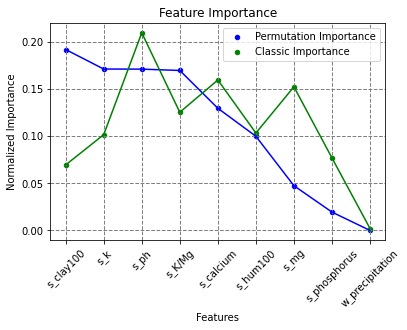

In [139]:
ax=perm_resultsdf.plot(x="pred", y="normalized", color='b', label='_nolegend_');
perm_resultsdf.plot.scatter(x="pred", y="normalized", color='b', label='Permutation Importance', ax=ax);
perm_resultsdf.plot(x="pred", y="feat_imp", color='g', label='_nolegend_', ax=ax);
perm_resultsdf.plot.scatter(x="pred", y="feat_imp", color='g', label='Classic Importance', ax=ax);
plt.xticks(rotation=45)
plt.grid(color='grey', linestyle='--', linewidth=1)
# Add title and axis names
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.legend(loc=0)
#perm_resultsdf.plot(xlabel="new x", ylabel="new y");

In [2]:
#pip install shap

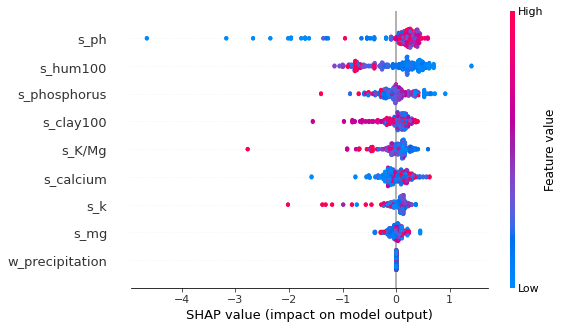

In [108]:
import shap  # pip install shap
import xgboost as xgb

# Load and train a model
#X, y = shap.datasets.diabetes()
clf = xgb.XGBRegressor().fit(X, y)

# Explain model's predictions with SHAP
explainer = shap.Explainer(clf)
shap_values = explainer(X)

# Visualize the predictions' explanation
#shap.plots.beeswarm(shap_values, show=False)
#shap.summary_plot(shap_values, final_model_features)
fig = plt.figure(figsize=(15,10))
fig = shap.summary_plot(shap_values,show=False)
plt.savefig('shap_bar_plot1.jpg',bbox_inches='tight', dpi=150)
#plt.savefig('scratch.png', show=False)#, show=False)
#plt.savefig('books_read.png')

In [103]:
%matplotlib inline

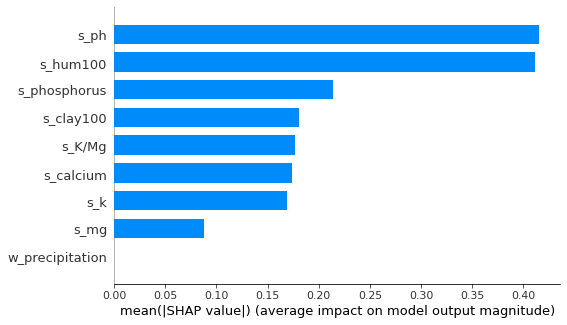

In [109]:
fig = plt.figure(figsize=(15,10))
shap.summary_plot(shap_values, X_train, plot_type="bar",show=False)
plt.savefig('shap_bar_plot2.jpg',bbox_inches='tight', dpi=150)
#plt.savefig('grafic.png', dpi=300, bbox_inches='tight')

AttributeError: 'Explanation' object has no attribute 'ndim'

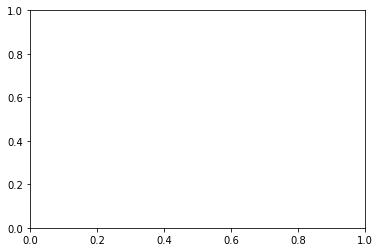

In [99]:
import matplotlib.pyplot as plt
#plt.plot(x,y)
plt.plot(shap_values)
plt.savefig('plot.png', dpi=300, bbox_inches='tight')

In [286]:
result = perm_resultsdf.keys()

# creating dataframe
df = pd.DataFrame({
    result[0]: perm_resultsdf[result[0]],
    result[1]: perm_resultsdf[result[1]]
})
#perm_resultsdf.values()

In [287]:
import pandas as pd
from matplotlib import pyplot as plt 
df.plot()

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

In [ ]:
df = pd.DataFrame(np.random.random_sample((10,2)), columns=['col1', 'col2'])
fig, ax = plt.subplots()

df['col1'].plot(kind='bar', ax=ax)
df['col2'].plot(ax=ax, marker='o', ls='-')
ax.legend(loc='best')

In [ ]:
import matplotlib.pyplot as plt
df.plot(x='pred',y='score', kind='bar')

In [ ]:

rf=RandomForestRegressor(n_estimators=100)#Classifier(n_estimators=100)
rf.fit(X_train, ny_train)

In [ ]:
def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    metric: sklearn metric, such as accuracy_score, precision_score or recall_score
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    #bar=progressbar.ProgressBar(max_value=len(X.columns))
    baseline_metric=metric(y, clf.predict(X))
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score=metric(y, clf.predict(X1))
            scores[c].append(baseline_metric-score)
        #bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [ ]:
baseline, scores=PermImportance(X_test, ny_test, rf, recall_score, num_iterations=10)

In [ ]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(list(y), list(oof_preds)))
print('XGBoost model accuracy score: {0:0.4f}'. format(gbm.score(X_test, y_test)))
print("Accuracy: %.2f%%" % (accuracy *100.0))

In [ ]:
from scipy.stats import norm

In [227]:
# Total difference between predicted and correct yield

dist = np.linalg.norm(list(y_test)-gbm.predict(X_test))
print("The total error for predicted yield (From the true yield) is (norm-2): ", dist)
print("The cross-validation score (5-split) is ", cv_score_)

The total error for predicted yield (From the true yield) is (norm-2):  0.002158976736021441
The cross-validation score (5-split) is  8.672742245509831e-05


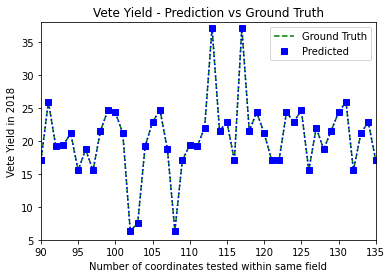

In [231]:
exact  = list(y_test)
approx = list(gbm.predict(X_test))

plt.plot(exact, '--g', label='Ground Truth')
plt.plot(exact, '.g')

plt.plot(approx,  'bs', label='Predicted')
plt.plot(approx, 'b:')
plt.ylabel('Vete Yield in 2018')
plt.xlabel('Number of coordinates tested within same field')
plt.title("Vete Yield - Prediction vs Ground Truth")
plt.axis([90, 135, 5, 38])
leg = plt.legend()
plt.show()

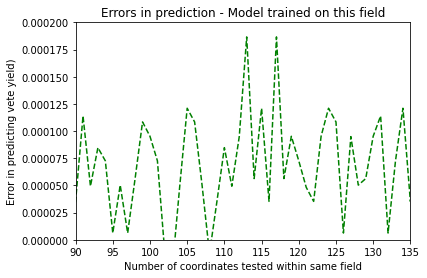

In [233]:

err = [exact[l]-approx[l] for l in range(len(exact))]

plt.plot(err, '--g')

plt.ylabel('Error in predicting vete yield)')
plt.xlabel('Number of coordinates tested within same field')
plt.title("Errors in prediction - Model trained on this field")
plt.axis([90, 135, 0, 0.0002])
#leg = plt.legend()
plt.show()

# Feature selection

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Top features - feature importance')

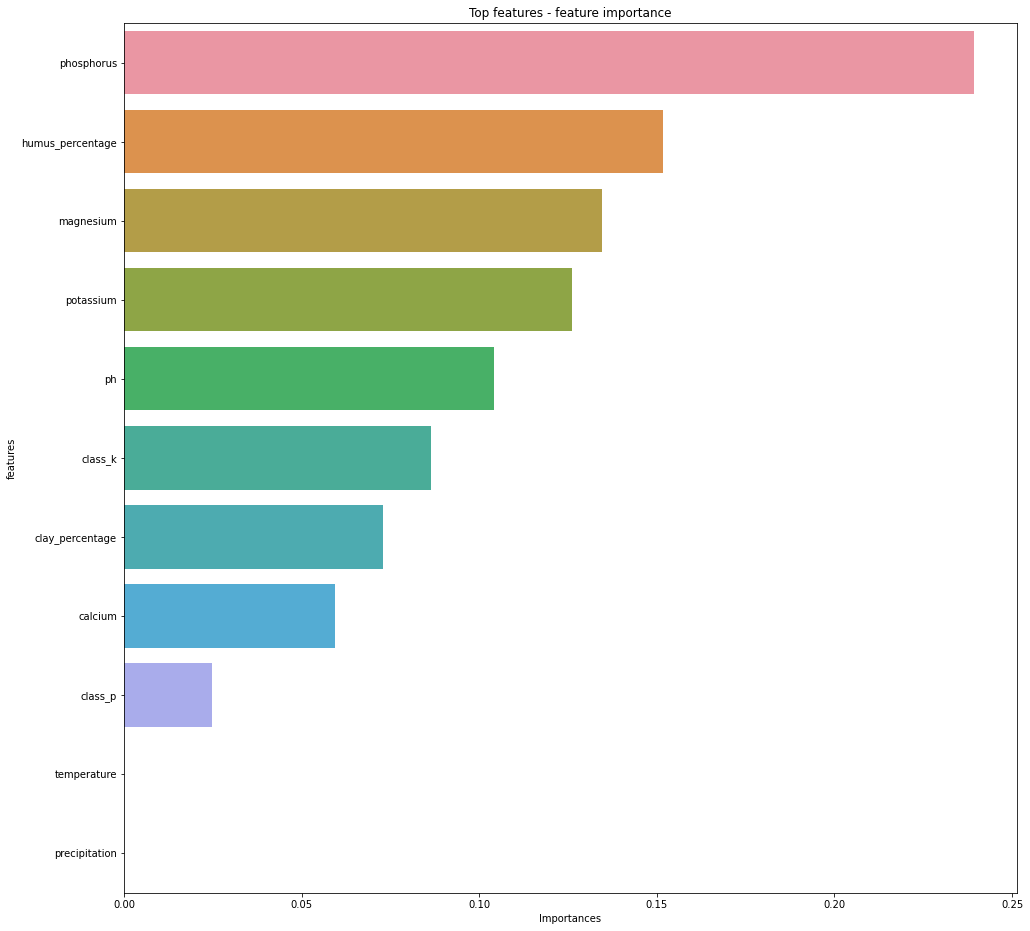

In [234]:
plt.figure(figsize=(16,16))
sns.barplot(data=feats.sort_values(by='Importances', ascending=False).head(70), x='Importances', y='features')
plt.title('Top features - feature importance')

In [ ]:
print("File ends here!")

File ends here!


In [340]:
label_count=len(np.floor(rev_y_train_unique))

In [303]:
%%time

# Set up training classes
rev_y_train = np.floor(y_train)#[np.argmax(y, axis=None, out=None) for y in y_train]
rev_y_train_unique = np.unique(rev_y_train)

# reshape features from count-timeframes-features to timeframes-count-features
#a, b, c = X_train.shape
#X_train_lgbm = X_train.reshape(a,b * c)
X_train_lgbm = X_train

# Set up the LightGBM model
model_lgbm = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=len(rev_y_train_unique), 
    metric='multi_logloss'
)

# Train the model
model_lgbm.fit(X_train_lgbm, rev_y_train)

# Save the model
#joblib.dump(model_lgbm, os.path.join(models_path, 'model_lgbm_CropTypeClass_{}.pkl'.format(grouping_id)))

<IPython.core.display.Javascript object>

CPU times: user 3min 51s, sys: 310 ms, total: 3min 51s
Wall time: 4.3 s


LGBMClassifier(metric='multi_logloss', num_class=11, objective='multiclass')

In [306]:
# reshape features from count-timeframes-features to timeframes-count-features
# and set up training classes
#d, e, f = X_test.shape
#X_test_lgbm = X_test.reshape(d, e * f)
X_test_lgbm = X_test
rev_y_test = np.floor(y_test)#[np.argmax(y, axis=None, out=None) for y in y_test]

# Load the models
#model_lgbm = joblib.load(os.path.join(models_path, 'model_lgbm_CropTypeClass_{}.pkl'.format(grouping_id)))
#model_tcnn = load_model(os.path.join(models_path, 'model_tcnn_CropTypeClass_{}.h5'.format(grouping_id)))

# get overall accuracy and weighted F1-score for LightGBM
py_test_lgbm = model_lgbm.predict(X_test_lgbm)
print('Classification accuracy LightGBM {:.1f}%'.format(100 * metrics.accuracy_score(rev_y_test, py_test_lgbm)))
print('Classification F1-score LightGBM {:.1f}%'.format(100 * metrics.f1_score(rev_y_test, py_test_lgbm, average='weighted')))

#py_test_tcnn = np.argmax(model_tcnn.predict(X_test), axis=-1)
#print('Classification accuracy TempCNN {:.1f}%'.format(100 * metrics.accuracy_score(rev_y_test, py_test_tcnn)))
#print('Classification F1-score TempCNN {:.1f}%'.format(100 * metrics.f1_score(rev_y_test, py_test_tcnn, average='weighted')))

Classification accuracy LightGBM 100.0%
Classification F1-score LightGBM 100.0%


In [325]:
#pip install eo-learn

In [322]:
# set module directory to system path
import sys, os
MAIN_FOLDER = os.getcwd()
temp_folder = "eo-learn-master/examples/crop-type-classification/"
# os.getcwd()
import_path = os.path.join(MAIN_FOLDER, temp_folder+'Tasks')
if import_path not in sys.path:
    sys.path.append(import_path)

In [334]:
from CropTypeClassTasks import plot_confusion_matrix, PredictPatch, AddAreaRatio, FixLPIS, masking
from CropTypeClassTasks import get_patch_list, train_test_split_eopatches, train_test_split_eopatch

In [327]:
fig = plt.figure(figsize=(20, 20))
conf_matrix_gbm = metrics.confusion_matrix(rev_y_test, py_test_lgbm)
plot_confusion_matrix(conf_matrix_gbm,
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
                      normalize=True,
                      ylabel='Truth (CROPS)',
                      xlabel='Predicted (LightGBM)',
                      title='Confusion matrix');

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'class_names' is not defined

<Figure size 1440x1440 with 0 Axes>

In [332]:
## Combine samples and split into train and test data
grouping_id=4
test_ratio = 4 # take every xth patch for testing
features_dict = 'FEATURES_SAMPLED' # name of the dictionary where the sample features are saved
labels_dict = 'LPIS_class_{}_ERODED_SAMPLED'.format(grouping_id) # name of the dictionary where the sample labels are saved
# Deep Learning
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.utils import to_categorical

In [336]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=None,test_size=0.25)
nX_train, nX_test, ny_train, ny_test, n_timesteps, n_features = train_test_split_eopatches(X,#eopatches, 
                                                                  test_ratio, 
                                                                  features_dict, 
                                                                  labels_dict)

KeyError: 0

In [341]:
%%time

n_timesteps= 175
n_features = 17
# Set up the TempCNN architecture
model_tcnn = Sequential()
model_tcnn.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_tcnn.add(Dropout(0.5))
model_tcnn.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_tcnn.add(Dropout(0.5))
model_tcnn.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model_tcnn.add(Dropout(0.5))
model_tcnn.add(Flatten())
model_tcnn.add(Dense(256, activation='relu'))
model_tcnn.add(Dense(label_count, activation='softmax'))
model_tcnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_tcnn.fit(X_train, 
          y_train, 
          validation_data=(X_test, y_test), 
          epochs=20, 
          batch_size=32, 
          verbose=1,  
          shuffle=True)

# Save the model
model_tcnn.save(os.path.join(models_path, 'model_tcnn_CropTypeClass_{}.h5'.format(grouping_id)))

Epoch 1/20


ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 11)


In [1]:

raise SystemExit("I stopped the code here. ")


SystemExit: I stopped the code here. 

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# pick_AOI = "Heddinge" 
# fieldID = "62233175597"#
# fieldID = "61663398164"#61653396999"
# linkhttp = "http://172.16.16.50:8080/fields/"+pick_AOI
# linkhttp = "http://172.16.16.50:8080/field/soil/"+fieldID+"?format={formats}&words={words}&paragraphs={paragraphs}"
# #linkhttp = "http://172.16.16.50:8080/field/weather/"+fieldID+"?format={formats}&words={words}&paragraphs={paragraphs}"
# #linkhttp = "http://172.16.16.50:8080/weather/Heddinge"
# #linkhttp = "http://172.16.16.50:8080/field/harvest/"+fieldID
# #linkhttp = "http://172.16.16.50:8080/fields/year/"+fieldID

# #linkhttp = "http://agri.snap.lab:8080/field/year/"+fieldID

# response = requests.get(linkhttp)
# response.text

In [ ]:
#    response = requests.get(linkhttp+"?format={formats}&words={words}&paragraphs={paragraphs}")
#    if response:
#        print('Request is successful.')
#        dataout = response.json()
#        print(response.text)
#    else:
#      print('Request returned an error.') 
#    #return dataout

In [122]:
X_test.iloc[1,:]

temperature          8.20
precipitation       10.00
ph                   6.80
calcium            180.00
class_k              4.00
class_p              4.00
magnesium            6.40
potassium           17.00
phosphorus           9.20
clay_percentage     13.00
humus_percentage     3.00
Name: 6, dtype: float64

In [248]:
from PIL import Image
from matplotlib.pyplot import imshow

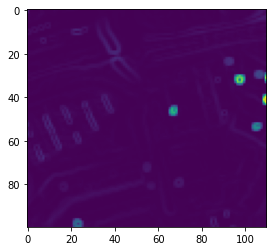

In [285]:
im = Image.open('heddingeImages/slope.tif')
im.show()
imarray = np.array(im)
imshow(np.asarray(imarray[100:200,490:600]))

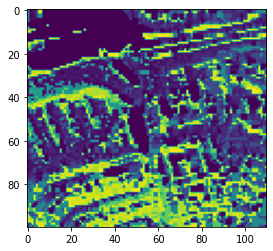

In [283]:
#im = Image.open('heddingeImages/flowacc.tif')
im = Image.open('heddingeImages/direction.tif')
imarray = np.array(im)
imshow(np.asarray(imarray[100:200,490:600]))
